<a href="https://colab.research.google.com/github/maruwrks/Deep-Learning-Task/blob/main/the_machine_learning_landscape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing, pipeline

##Data Preparation

In [2]:
np.random.seed(42)
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
datapath = os.path.join("datasets", "lifesat", "")
os.makedirs(datapath, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
for filename in ("oecd_bli_2015.csv", "gdp_per_capita.csv"):
    urllib.request.urlretrieve(DOWNLOAD_ROOT + "datasets/lifesat/" + filename, datapath + filename)

## Data Loading

In [4]:
oecd_bli = pd.read_csv(datapath + "oecd_bli_2015.csv", thousands=',')
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")

In [5]:
gdp_per_capita = pd.read_csv(datapath + "gdp_per_capita.csv", thousands=',', delimiter='\t',
                             encoding='latin1', na_values="n/a")
gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
gdp_per_capita.set_index("Country", inplace=True)

In [6]:
full_country_stats = pd.merge(oecd_bli, gdp_per_capita, left_index=True, right_index=True)
full_country_stats.sort_values(by="GDP per capita", inplace=True)

In [7]:
remove_indices = [0, 1, 6, 8, 33, 34, 35]
keep_indices = list(set(range(36)) - set(remove_indices))
sample_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices]
missing_data = full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[remove_indices]

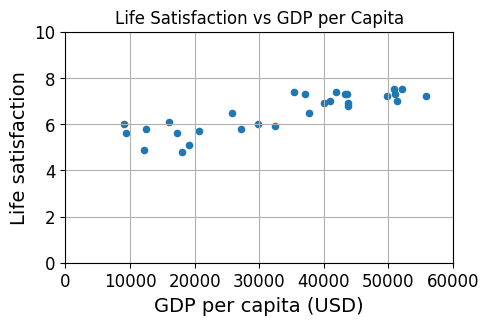

In [8]:
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.axis([0, 60000, 0, 10])
plt.xlabel("GDP per capita (USD)")
plt.ylabel("Life satisfaction")
plt.title("Life Satisfaction vs GDP per Capita")
plt.grid(True)
plt.show()

##Model Baseline

In [9]:
lin_reg = linear_model.LinearRegression()
X_sample = np.c_[sample_data["GDP per capita"]]
y_sample = np.c_[sample_data["Life satisfaction"]]
lin_reg.fit(X_sample, y_sample)
t0, t1 = lin_reg.intercept_[0], lin_reg.coef_[0][0]

###Predict

In [10]:
cyprus_gdp = gdp_per_capita.loc["Cyprus"]["GDP per capita"]
cyprus_pred = lin_reg.predict([[cyprus_gdp]])[0][0]

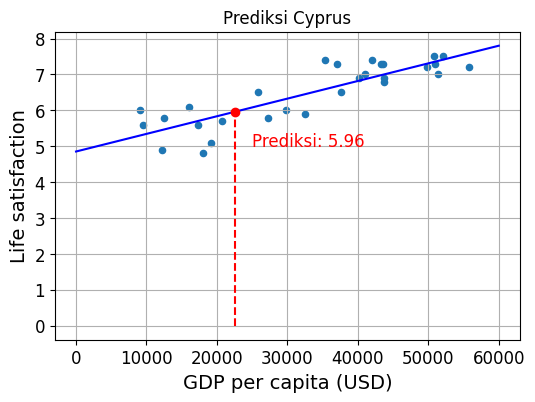

In [11]:
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(6,4))
X = np.linspace(0, 60000, 1000)
plt.plot(X, t0 + t1 * X, "b")
plt.plot(cyprus_gdp, cyprus_pred, "ro")
plt.plot([cyprus_gdp, cyprus_gdp], [0, cyprus_pred], "r--")
plt.text(25000, 5.0, f"Prediksi: {cyprus_pred:.2f}", fontsize=12, color="r")
plt.xlabel("GDP per capita (USD)")
plt.ylabel("Life satisfaction")
plt.title("Prediksi Cyprus")
plt.grid(True)
plt.show()

###Model Full

In [12]:
lin_reg_full = linear_model.LinearRegression()
X_full = np.c_[full_country_stats["GDP per capita"]]
y_full = np.c_[full_country_stats["Life satisfaction"]]
lin_reg_full.fit(X_full, y_full)

LinearRegression()

###Ridge Regression

In [14]:
ridge = linear_model.Ridge(alpha=10**9.5)
ridge.fit(X_sample, y_sample)
t0_ridge = ridge.intercept_[0]
t1_ridge = ridge.coef_[0]

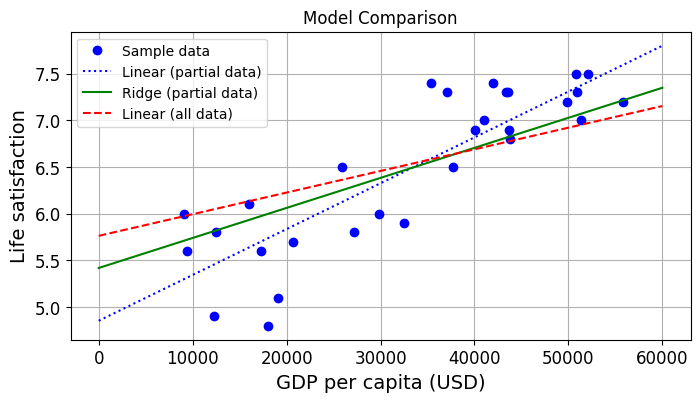

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(X_sample, y_sample, "bo", label="Sample data")
plt.plot(X, t0 + t1*X, "b:", label="Linear (partial data)")
plt.plot(X, t0_ridge + t1_ridge*X, "g-", label="Ridge (partial data)")
plt.plot(X, lin_reg_full.intercept_[0] + lin_reg_full.coef_[0][0]*X, "r--", label="Linear (all data)")
plt.xlabel("GDP per capita (USD)")
plt.ylabel("Life satisfaction")
plt.title("Model Comparison")
plt.legend()
plt.grid(True)
plt.show()

##Overfitting example

In [17]:
poly_features = preprocessing.PolynomialFeatures(degree=30, include_bias=False)
scaler = preprocessing.StandardScaler()
lin_reg2 = linear_model.LinearRegression()
pipeline_reg = pipeline.Pipeline([
    ("poly", poly_features),
    ("scaler", scaler),
    ("lin_reg", lin_reg2)
])
pipeline_reg.fit(X_full, y_full)
y_pred_curve = pipeline_reg.predict(X[:, np.newaxis])

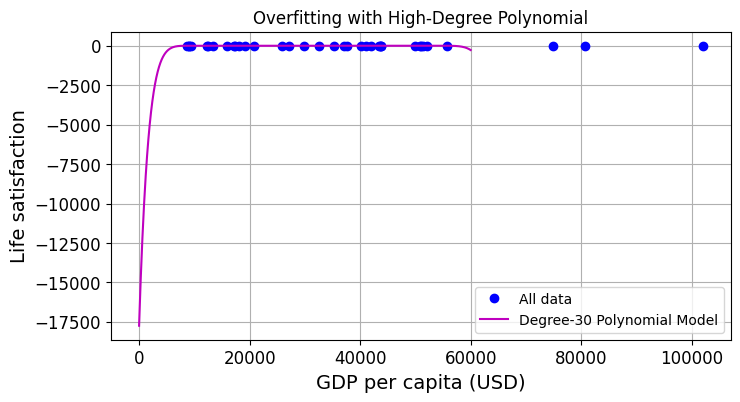

In [18]:
plt.figure(figsize=(8, 4))
plt.plot(X_full, y_full, "bo", label="All data")
plt.plot(X, y_pred_curve, "m-", label="Degree-30 Polynomial Model")
plt.xlabel("GDP per capita (USD)")
plt.ylabel("Life satisfaction")
plt.title("Overfitting with High-Degree Polynomial")
plt.legend()
plt.grid(True)
plt.show()